In [1]:
from extract_text import TextExtractor

/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
impressions="right pleural effusion and no left pleural effusion"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/text_embed"  
file_name='aidan_kate_test_rightpleur_noleft.npy'

In [3]:
text_extractor = TextExtractor(resume_model="/media/volume/gen-ai-volume/MedSyn/models/test_run2")
text_extractor.run(impressions, output_folder, file_name)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of CXRBertModel were not initialized from the model checkpoint at microsoft/BiomedVLP-CXR-BERT-specialized and are newly initialized: ['classifier.bias

<All keys matched successfully>
File already exists: /media/volume/gen-ai-volume/MedSyn/results/text_embed/aidan_kate_test_rightpleur_noleft.npy and /media/volume/gen-ai-volume/MedSyn/results/text_embed/aidan_kate_test_rightpleur_noleft_tokens.npy


In [ ]:
from stage1 import run_diffusion_1
import accelerate
accelerate.state.AcceleratorState._shared_state.clear() # dirty hack to reset accelerator state
run_diffusion_1(input_folder="/media/volume/gen-ai-volume/MedSyn/results/text_embed", 
                output_folder= "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/aidan_kate_test_rightpleur_noleft", 
                model_folder="/media/volume/gen-ai-volume/MedSyn/models/stage1", 
                attention_folder="/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/aidan_kate_test_rightpleur_noleft",
                dont_delete_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard",
                num_sample=1,
                tokenizer=text_extractor.tokenizer,
                noise_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/saved_noise/aidan_kate_test_rightpleur_noleft")

In [9]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm

generated_filename = "aidan_kate_test_rightpleur_noleft_sample_0.npy"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/aidan_kate_test_rightpleur_noleft"
image_path = os.path.join(output_folder, generated_filename)

generated_image = np.load(image_path)  # Shape: (C, D, H, W) or (C, num_slices, height, width)
print(f"Loaded image shape: {generated_image.shape}")  # Check image dimensions

Loaded image shape: (4, 64, 64, 64)


In [7]:
from scipy.ndimage import zoom
import numpy as np
import matplotlib.pyplot as plt
import os

Loaded generated images with shape: (4, 64, 64, 64)
Sample shape: (64, 64, 64)
Loaded CLS heatmaps with shape: (64, 8, 8)
Final heatmap volume shape: (64, 64, 64)


<Figure size 1500x1500 with 0 Axes>

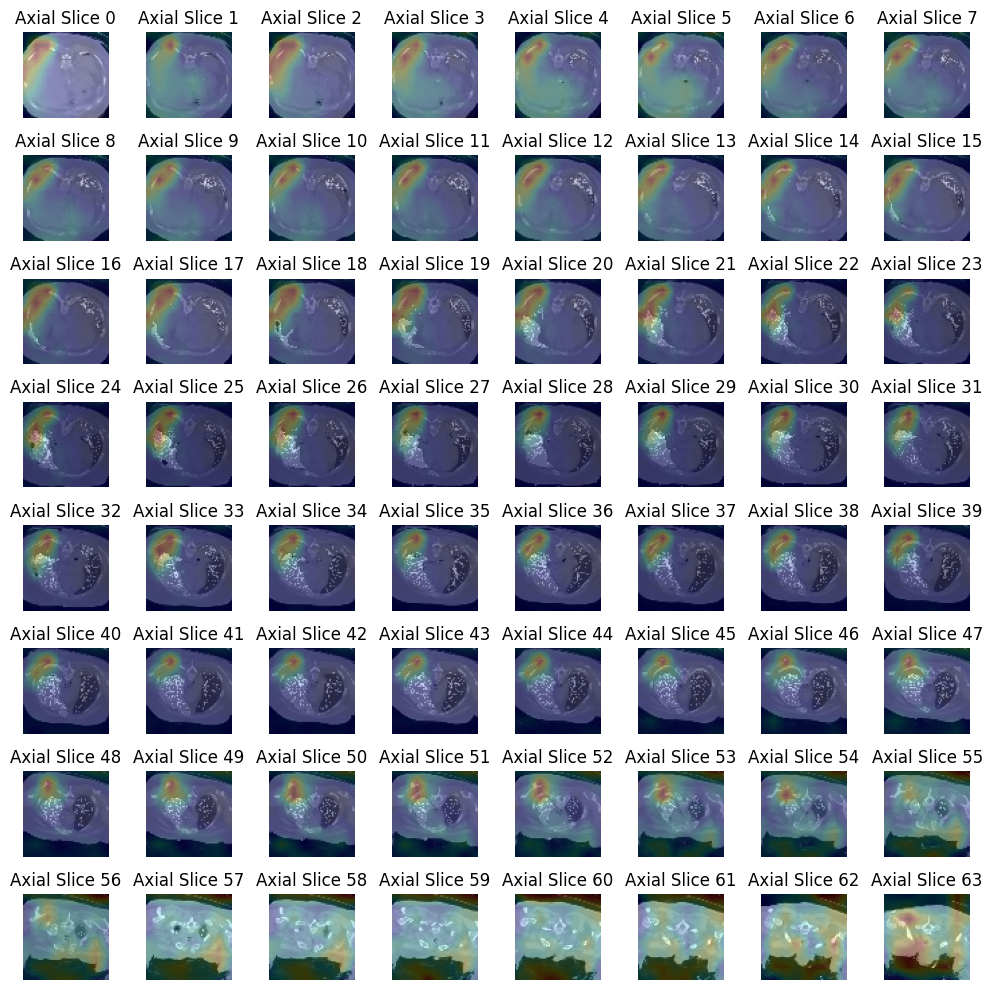

In [15]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min + 1e-8)

def overlay_heatmap_on_slices(volume, heatmap_volume, view='axial', n_rows=8, n_cols=8):
    if view == 'axial':
        slices = volume
        heatmap_slices = heatmap_volume
    elif view == 'coronal':
        slices = np.transpose(volume, (1, 0, 2))
        heatmap_slices = np.transpose(heatmap_volume, (1, 0, 2))
    elif view == 'sagittal':
        slices = np.transpose(volume, (2, 0, 1))
        heatmap_slices = np.transpose(heatmap_volume, (2, 0, 1))
    else:
        raise ValueError("Invalid view. Choose from 'axial', 'coronal', or 'sagittal'.")

    num_slices = slices.shape[0]
    total_plots = n_rows * n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axes = axes.flatten()

    for idx in range(total_plots):
        slice_idx = idx  # You can customize the slice indices if needed
        if slice_idx >= num_slices:
            axes[idx].axis('off')
            continue

        image_slice = slices[slice_idx, :, :]
        image_slice_norm = normalize_image(image_slice)

        heatmap_slice = heatmap_slices[slice_idx, :, :]
        heatmap_slice_norm = normalize_image(heatmap_slice)

        axes[idx].imshow(image_slice_norm, cmap='gray')
        axes[idx].imshow(heatmap_slice_norm, cmap='jet', alpha=0.2)

        axes[idx].set_title(f'{view.capitalize()} Slice {slice_idx}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

image_data_path = image_path
heatmap_data_path = '/media/volume/gen-ai-volume/MedSyn/results/saliency_maps/aidan_kate_test_rightpleur_noleft/aidan_kate_test_rightpleur_noleft_sample_0.npy_token_1_right_heatmaps.npy'

# Load the generated images
data = np.load(image_data_path)
print(f"Loaded generated images with shape: {data.shape}")

#add a dummy batch dimension
data_batched = np.expand_dims(data, axis=0)

# Average over channels if multiple channels exist
sample = data_batched[0].mean(axis=0)  # [frames, height, width]
num_frames, height, width = sample.shape
print(f"Sample shape: {sample.shape}")
sample_norm = normalize_image(sample)
heatmaps = np.load(heatmap_data_path)
print(f"Loaded CLS heatmaps with shape: {heatmaps.shape}")
if heatmaps.shape[1] != height or heatmaps.shape[2] != width:
    resized_heatmaps = []
    for i in range(num_frames):
        heatmap_slice = heatmaps[i, :, :]  # e.g. (8, 8)
        heatmap_slice_norm = normalize_image(heatmap_slice)
        zoom_factors = (height / heatmap_slice.shape[0], width / heatmap_slice.shape[1])
        heatmap_resized = zoom(heatmap_slice_norm, zoom_factors, order=1)  # Bilinear interpolation
        resized_heatmaps.append(heatmap_resized)
    heatmap_volume = np.stack(resized_heatmaps, axis=0)  # (frames, height, width)
else:
    heatmap_volume = heatmaps

print(f"Final heatmap volume shape: {heatmap_volume.shape}")
view = 'axial'

plt.figure(figsize=(15, 15))
plt.suptitle(f"Overlay of CLS Heatmaps - View: {view.capitalize()}", fontsize=16)
overlay_heatmap_on_slices(sample_norm, heatmap_volume, view=view, n_rows=8, n_cols=8)

<Figure size 1500x1500 with 0 Axes>

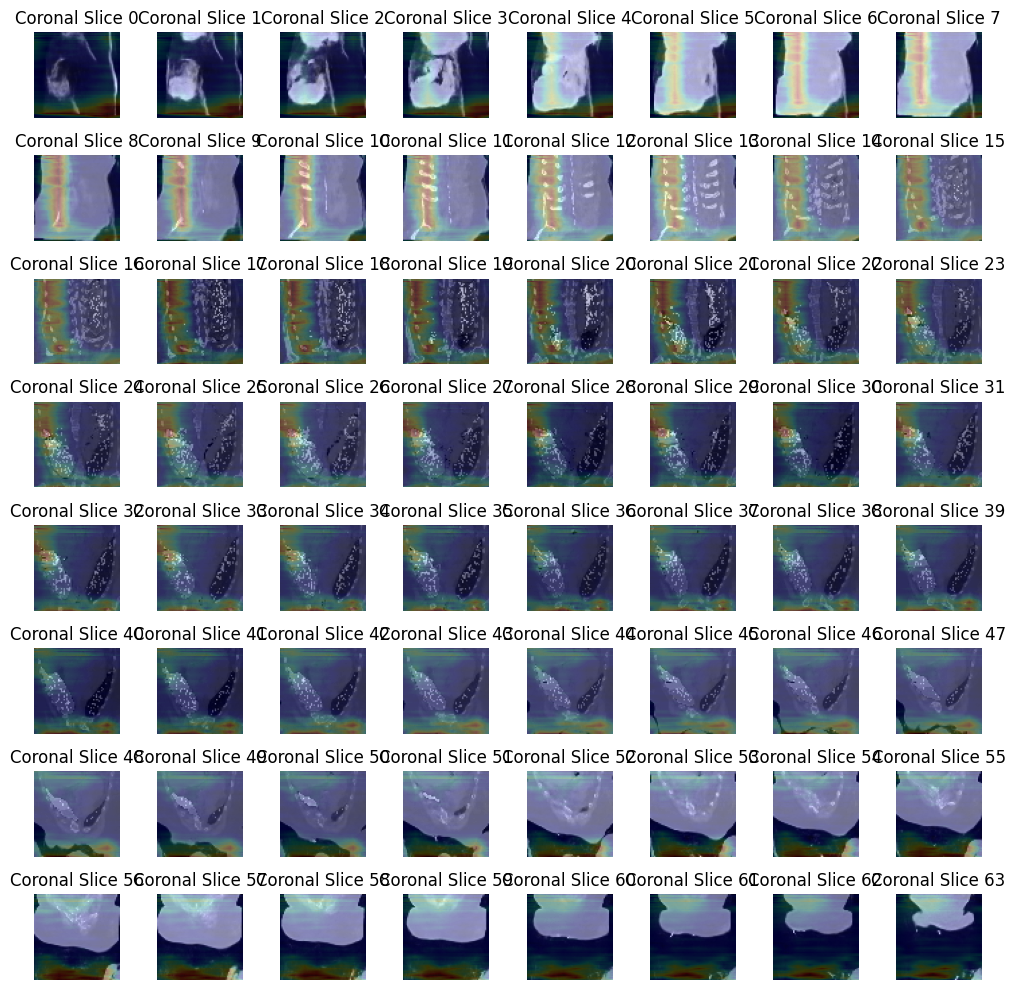

In [16]:
view = 'coronal'

plt.figure(figsize=(15, 15))
plt.suptitle(f"Overlay of CLS Heatmaps - View: {view.capitalize()}", fontsize=16)
overlay_heatmap_on_slices(sample_norm, heatmap_volume, view=view, n_rows=8, n_cols=8)

<Figure size 1500x1500 with 0 Axes>

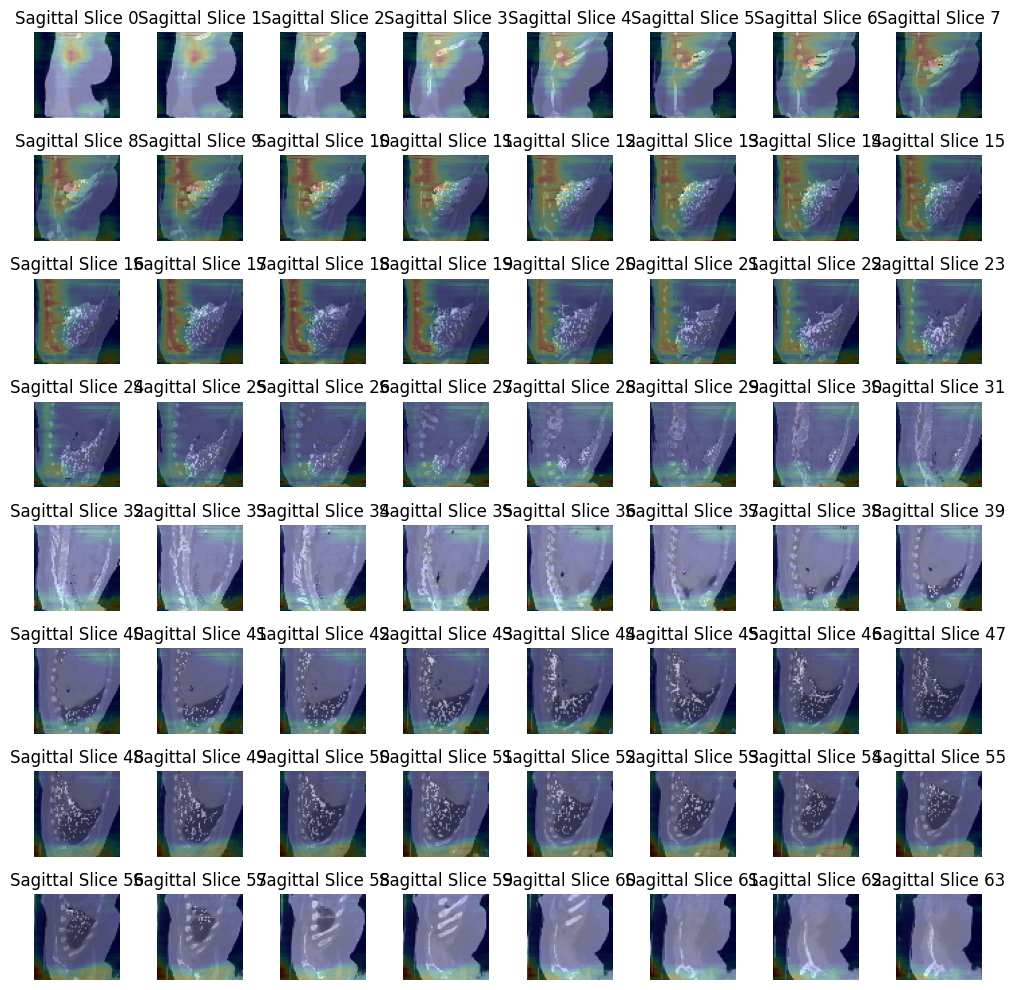

In [17]:
view = 'sagittal'

plt.figure(figsize=(15, 15))
plt.suptitle(f"Overlay of CLS Heatmaps - View: {view.capitalize()}", fontsize=16)
overlay_heatmap_on_slices(sample_norm, heatmap_volume, view=view, n_rows=8, n_cols=8)